## Todo

- comparar leitos cnes com leitos api, ver se está muito fora
- medidas de desatualização por estado e tipo de gestão

In [123]:
import pandas as pd
import numpy as np
import json
from datetime import datetime, timezone, timedelta
import time
import glob
import gzip
import requests

In [2]:
# # dt_run = datetime.datetime.strptime('2021-02-18', '%Y-%m-%d')
# dt_run = datetime.now(timezone.utc) # UTC time
# print(dt_run)

2021-03-03 17:35:07.750614+00:00


## Ler dados

In [6]:
DATA_FOLDER = 'data/leitos/'

In [7]:
data_files = glob.glob(f'{DATA_FOLDER}data_*.json.gz')
data_files.sort(reverse=True)
DATA_FILE = data_files[0]
print(DATA_FILE)

data/leitos/data_2021-03-03.json.gz


In [8]:
with gzip.open(DATA_FILE, 'r') as fin:
    data = json.loads(fin.read().decode('utf-8'))

In [9]:
# file_dt_string = DATA_FILE.split('/')[-1].split('.')[0].split('_')[-1]
# DT_RUN = datetime.strptime(file_dt_string, '%Y-%m-%d')
# print(DT_RUN)

In [10]:
TS_RUN = pd.to_datetime(data['ts_run'])

In [11]:
hits = data['hits']['hits']
df = pd.json_normalize(hits)

df.columns.values
df.columns = [x.replace('_source.', '') for x in df.columns.values]

df.head()

,_index,_type,_id,_score,estado,estadoSigla,municipio,cnes,nomeCnes,dataNotificacaoOcupacao,...,ofertaSRAGCli,ofertaSRAGUti,ocupHospCli,ocupHospUti,ocupSRAGCli,ocupSRAGUti,altas,obitos,ocupacaoInformada,algumaOcupacaoInformada
0,leito_ocupacao,_doc,2712016,1.0,Pernambuco,PE,Sertânia,2712016,HOSPITAL MARIA ALICE GOMES LAFAYETTE,2020-11-27T03:00:19.869Z,...,18.0,0.0,6.0,0.0,4.0,0,0.0,0,True,True
1,leito_ocupacao,_doc,0116335,1.0,Pará,PA,Marabá,0116335,HOSPITAL DE CAMPANHA COVID 19 MARABA,2020-11-26T03:00:19.985Z,...,89.0,31.0,0.0,0.0,3.0,0,0.0,0,True,True
2,leito_ocupacao,_doc,12769,1.0,Rio de Janeiro,rj,Niterói,12769,NaN,2020-10-18T03:00:09.902Z,...,NaN,NaN,19.0,0.0,1.0,7,0.0,0,True,True
3,leito_ocupacao,_doc,2547317,1.0,Espírito Santo,ES,São José do Calçado,2547317,HOSPITAL SAO JOSE,2020-10-18T03:00:12.938Z,...,0.0,0.0,26.0,8.0,0.0,0,0.0,0,True,True
4,leito_ocupacao,_doc,9614990,1.0,Paraná,pr,Marechal Cândido Rondon,9614990,NaN,2020-08-10T03:00:34.126Z,...,NaN,NaN,3.0,0.0,4.0,0,2.0,0,True,True


In [12]:
df.columns.values

array(['_index', '_type', '_id', '_score', 'estado', 'estadoSigla',
       'municipio', 'cnes', 'nomeCnes', 'dataNotificacaoOcupacao',
       'ofertaRespiradores', 'ofertaHospCli', 'ofertaHospUti',
       'ofertaSRAGCli', 'ofertaSRAGUti', 'ocupHospCli', 'ocupHospUti',
       'ocupSRAGCli', 'ocupSRAGUti', 'altas', 'obitos',
       'ocupacaoInformada', 'algumaOcupacaoInformada'], dtype=object)

## Limpar e criar features

### Considerando oferta sem ocupação

In [13]:
df['totalOfertaCli'] = df['ofertaHospCli'] + df['ofertaSRAGCli']
df['totalOfertaUti'] = df['ofertaHospUti'] + df['ofertaSRAGUti']
df['totalOcupCli'] = df['ocupHospCli'] + df['ocupSRAGCli']
df['totalOcupUti'] = df['ocupHospUti'] + df['ocupSRAGUti']

### Considerando oferta como oferta + ocupação

In [14]:
df['totalOfertaCliAlt'] = df['ofertaHospCli'] + df['ofertaSRAGCli'] + df['ocupHospCli'] + df['ocupSRAGCli']
df['totalOfertaUtiAlt'] = df['ofertaHospUti'] + df['ofertaSRAGUti'] + df['ocupHospUti'] + df['ocupSRAGUti']

### Tem UTI

- Tem alguma vaga ou ocupação de UTI, Hosp ou SRAG

In [195]:
df['has_uti_proxy'] = np.where(df['totalOfertaUtiAlt'] > 0, True, False)

### Colunas de tempo

In [15]:
df['dataNotificacaoOcupacao'] = pd.to_datetime(df['dataNotificacaoOcupacao'])

In [137]:
UPDATED_DAYS = [7, 14, 90]
for d in UPDATED_DAYS:
    df[f'updated_{str(d)}d'] = np.where(df['dataNotificacaoOcupacao'] >= TS_RUN - timedelta(days=d), True, False)

In [138]:
for d in UPDATED_DAYS:
    pct_outdated = len(df[df[f'updated_{str(d)}d'] == True]) / len(df)
    print(f'{round(pct_outdated * 100, 1)}% updated in {str(d)} days')

64.4% updated in 7 days
66.9% updated in 14 days
75.1% updated in 90 days


In [139]:
df[df['updated_90d'] == False]

,_index,_type,_id,_score,estado,estadoSigla,municipio,cnes,nomeCnes,dataNotificacaoOcupacao,...,totalOcupCli,totalOcupUti,totalOfertaCliAlt,totalOfertaUtiAlt,outdated_7d,outdated_14d,outdated_90d,updated_7d,updated_14d,updated_90d
0,leito_ocupacao,_doc,2712016,1.0,Pernambuco,PE,Sertânia,2712016,HOSPITAL MARIA ALICE GOMES LAFAYETTE,2020-11-27 03:00:19.869000+00:00,...,10.0,0.0,82.0,0.0,True,True,True,False,False,False
1,leito_ocupacao,_doc,0116335,1.0,Pará,PA,Marabá,0116335,HOSPITAL DE CAMPANHA COVID 19 MARABA,2020-11-26 03:00:19.985000+00:00,...,3.0,0.0,172.0,31.0,True,True,True,False,False,False
2,leito_ocupacao,_doc,12769,1.0,Rio de Janeiro,rj,Niterói,12769,NaN,2020-10-18 03:00:09.902000+00:00,...,20.0,7.0,NaN,NaN,True,True,True,False,False,False
3,leito_ocupacao,_doc,2547317,1.0,Espírito Santo,ES,São José do Calçado,2547317,HOSPITAL SAO JOSE,2020-10-18 03:00:12.938000+00:00,...,26.0,8.0,92.0,18.0,True,True,True,False,False,False
4,leito_ocupacao,_doc,9614990,1.0,Paraná,pr,Marechal Cândido Rondon,9614990,NaN,2020-08-10 03:00:34.126000+00:00,...,7.0,0.0,NaN,NaN,True,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,leito_ocupacao,_doc,7399626,1.0,Ceará,ce,Russas,7399626,NaN,2020-06-18 12:14:59.537000+00:00,...,0.0,0.0,NaN,NaN,True,True,True,False,False,False
3597,leito_ocupacao,_doc,7460953,1.0,Ceará,ce,Iguatu,7460953,NaN,2020-06-19 17:22:49.827000+00:00,...,0.0,0.0,NaN,NaN,True,True,True,False,False,False
3599,leito_ocupacao,_doc,7514948,1.0,Ceará,CE,Fortaleza,7514948,UNIDADE PRONTO ATENDIMENTO ITAPERI,2020-05-04 11:37:56.347000+00:00,...,0.0,0.0,40.0,0.0,True,True,True,False,False,False
3612,leito_ocupacao,_doc,9346309,1.0,Ceará,CE,Caucaia,9346309,UNIDADE DE PRONTO ATENDIMENTO DA JUREMA,2020-05-01 17:13:50.550000+00:00,...,0.0,0.0,19.0,0.0,True,True,True,False,False,False


### Consulta CNES

In [31]:
STANDARD_HEADERS = {
    'Connection': 'keep-alive',
    'Pragma': 'no-cache',
    'Cache-Control': 'no-cache',
    'Accept': 'application/json, text/plain, */*',
    'Referer': 'http://cnes.datasus.gov.br/pages/estabelecimentos/consulta.jsp',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36',
}

In [41]:
def get_basic_info_by_cnes(cnes):
    params = (
        ('cnes', cnes),
    )
    r = requests.get('http://cnes.datasus.gov.br/services/estabelecimentos', headers=STANDARD_HEADERS, params=params, verify=False)
    return json.loads(r.content)

In [49]:
def get_detailed_info(id):
    r = requests.get(f'http://cnes.datasus.gov.br/services/estabelecimentos/{id}', headers=STANDARD_HEADERS, verify=False)
    return json.loads(r.content)

In [72]:
def get_beds(id):
    r = requests.get(f'http://cnes.datasus.gov.br/services/estabelecimentos-hospitalar/{id}', headers=STANDARD_HEADERS, verify=False)
    return json.loads(r.content)

In [48]:
def check_if_deactivated(id):
    # returns True is deactivated, false otherwise
    r = requests.get(f'http://cnes.datasus.gov.br/services/estabelecimentos-desativados-local/validar/{id}', headers=STANDARD_HEADERS, verify=False)
    return json.loads(r.content)['existe']

In [96]:
def get_all_info(cnes):
    basic_info = get_basic_info_by_cnes(cnes)
    # display(basic_info)
    first_match = basic_info[0]
    id = str(first_match['id'])

    beds = get_beds(id)
    detailed_info = get_detailed_info(id)
    deactivated = check_if_deactivated(id)
    
    detailed_info['beds'] = beds
    detailed_info['deactivated'] = deactivated
    return detailed_info

In [124]:
def get_all_hospital_data(df):
    ts_run = datetime.now(timezone.utc)
    cnes_codes = df[:].cnes.unique()
    counter = 1
    errors = []
    start_time = time.time()
    end_time = time.time()

    for cnes in cnes_codes:
        print(cnes, f'{counter}/{len(cnes_codes)}')
        try:
            info = get_all_info(cnes)
            info['ts_run'] = ts_run.isoformat()
            info['error'] = False
            with open(f'data/hospitais/{cnes}.json', 'w') as outfile:
                json.dump(info, outfile)
        except Exception as e:
            print('error:', e)
            errors.append(cnes)
            with open(f'data/hospitais/{cnes}.json', 'w') as outfile:
                json.dump({'cnes': cnes, 'error': True}, outfile)
        finally:
            counter += 1

    time_elapsed = (end_time - start_time)
    print(time_elapsed)
    return errors

2712016 1/3816
0116335 2/3816
12769 3/3816
error: list index out of range
2547317 4/3816
9614990 5/3816
9768 6/3816
error: list index out of range
2509636 7/3816
2687011 8/3816
2711451  9/3816
error: list index out of range
708203113539445 10/3816
error: list index out of range
2356449 11/3816
2699850 12/3816
2593874 13/3816
2012618 14/3816
2017997 15/3816
2080516 16/3816
2081288 17/3816
2102579 18/3816
2117037 19/3816
2118459 20/3816
2144557 21/3816
2144611 22/3816
2160498 23/3816
2167565 24/3816
2206498 25/3816
2248220 26/3816
2295075 27/3816
2300435 28/3816
2311992 29/3816
2313367 30/3816
2322730 31/3816
2323915 32/3816
2330938 33/3816
2333430 34/3816
2340992 35/3816
2350289 36/3816
2386569 37/3816
2400243 38/3816
2417189 39/3816
2417456 40/3816
2426749 41/3816
2448173 42/3816
2493195 43/3816
2506572 44/3816
2526670 45/3816
2527413 46/3816
2537028 47/3816
2554771 48/3816
2557118 49/3816
2561042 50/3816
2561425 51/3816
2563479 52/3816
2566168 53/3816
2572443 54/3816
2573172 55/3816
2

2794136 350/3816
2611635 351/3816
2421542 352/3816
9126597 353/3816
2712008 354/3816
2761068 355/3816
2012499 356/3816
0102091 357/3816
3225798 358/3816
6569803 359/3816
2382601 360/3816
2392380 361/3816
6414702 362/3816
5478898 363/3816
2636832 364/3816
2720043 365/3816
2013606 366/3816
2288230 367/3816
2798484 368/3816
2330962 369/3816
2437538 370/3816
3063216 371/3816
0501238 372/3816
error: list index out of range
0005428 373/3816
0013846 374/3816
204325308210007 375/3816
error: list index out of range
2742020 376/3816
7073224 377/3816
2287285 378/3816
2273411 379/3816
2582058 380/3816
2139065 381/3816
2761149 382/3816
2595265 383/3816
0110337 384/3816
2492342 385/3816
6599877 386/3816
4022718 387/3816
2499851 388/3816
2127938 389/3816
2599643 390/3816
2114763 391/3816
2119455 392/3816
6601804 393/3816
5018110 394/3816
8015899 395/3816
2452383 396/3816
3569543 397/3816
6852300 398/3816
3371980 399/3816
2760886 400/3816
2639246 401/3816
2115654 402/3816
2704633 403/3816
0134252 404/

2336960 814/3816
2337525 815/3816
2337800 816/3816
2337851 817/3816
2338114 818/3816
2338149 819/3816
2338181 820/3816
2338734 821/3816
2339234 822/3816
2340526 823/3816
2340593 824/3816
2340690 825/3816
2341093 826/3816
2360470 827/3816
2361221 828/3816
2371138 829/3816
2371375 830/3816
2372568 831/3816
2372622 832/3816
2372819 833/3816
2372967 834/3816
2375265 835/3816
2375680 836/3816
2375826 837/3816
2376075 838/3816
2376598 839/3816
2376652 840/3816
2376776 841/3816
2376873 842/3816
2381966 843/3816
2381974 844/3816
2381990 845/3816
2382237 846/3816
2382415 847/3816
2382466 848/3816
2382687 849/3816
2382709 850/3816
2382814 851/3816
2382911 852/3816
2382938 853/3816
2383012 854/3816
2383462 855/3816
2383489 856/3816
2383578 857/3816
2383896 858/3816
2384035 859/3816
2391163 860/3816
2391503 861/3816
2391635 862/3816
2391724 863/3816
2391791 864/3816
2392399 865/3816
2392410 866/3816
2392887 867/3816
2392895 868/3816
2394820 869/3816
2395398 870/3816
2395479 871/3816
2395509 872/38

6755771 1276/3816
6871747 1277/3816
 980016289473382 1278/3816
error: list index out of range
7050004 1279/3816
error: list index out of range
9994289 1280/3816
9709 1281/3816
error: list index out of range
9717 1282/3816
error: list index out of range
2711877 1283/3816
9997032 1284/3816
0119172 1285/3816
2010356 1286/3816
2016672 1287/3816
2139138 1288/3816
2140179 1289/3816
2206420 1290/3816
2269899 1291/3816
2270234 1292/3816
2270617 1293/3816
2270803 1294/3816
2274108 1295/3816
2314037 1296/3816
2314436 1297/3816
2316013 1298/3816
2327945 1299/3816
2327961 1300/3816
2328399 1301/3816
2328534 1302/3816
2329905 1303/3816
2331861 1304/3816
2376261 1305/3816
2381885 1306/3816
2382164 1307/3816
2402564 1308/3816
2445247 1309/3816
2448424 1310/3816
2457768 1311/3816
2459477 1312/3816
2482339 1313/3816
2493845 1314/3816
2520613 1315/3816
2561026 1316/3816
2561069 1317/3816
2561441 1318/3816
2572257 1319/3816
2573032 1320/3816
2582430 1321/3816
2638835 1322/3816
2664992 1323/3816
2666626 1

2616513 1566/3816
2587734 1567/3816
2361884 1568/3816
2344858 1569/3816
7975023 1570/3816
2278332 1571/3816
2317028 1572/3816
2278391 1573/3816
2711893 1574/3816
2380633 1575/3816
7639724 1576/3816
2639114 1577/3816
2733358 1578/3816
2658372 1579/3816
0150312 1580/3816
0113115 1581/3816
2287927 1582/3816
 0127752 1583/3816
error: list index out of range
5095808 1584/3816
0119377 1585/3816
0010545 1586/3816
4051513 1587/3816
2448521 1588/3816
3276678 1589/3816
3625087 1590/3816
4047184 1591/3816
2119471 1592/3816
0119016 1593/3816
2583712 1594/3816
2104741 1595/3816
2001020 1596/3816
2127997 1597/3816
2018381 1598/3816
2120402 1599/3816
6025692 1600/3816
9012842 1601/3816
2639092 1602/3816
2270390 1603/3816
2270714 1604/3816
2273187 1605/3816
2273349 1606/3816
2277301 1607/3816
2280728 1608/3816
2291266 1609/3816
2298120 1610/3816
5717256 1611/3816
7041624 1612/3816
7166494 1613/3816
2269724 1614/3816
2269945 1615/3816
2384124 1616/3816
2195224 1617/3816
2425343 1618/3816
2012839 1619/3

2077485 2005/3816
2077507 2006/3816
2077515 2007/3816
2077574 2008/3816
2077612 2009/3816
2077639 2010/3816
2077671 2011/3816
2077957 2012/3816
2078015 2013/3816
2078252 2014/3816
2078287 2015/3816
2078384 2016/3816
2078449 2017/3816
2078562 2018/3816
2078902 2019/3816
2079011 2020/3816
2079291 2021/3816
2079321 2022/3816
2079550 2023/3816
2079704 2024/3816
2079798 2025/3816
2079917 2026/3816
2080044 2027/3816
2080125 2028/3816
2080222 2029/3816
2080273 2030/3816
2080354 2031/3816
2080370 2032/3816
2080400 2033/3816
2080427 2034/3816
2080443 2035/3816
2080494 2036/3816
2080524 2037/3816
2080532 2038/3816
2080583 2039/3816
2080680 2040/3816
2080745 2041/3816
2080842 2042/3816
2080958 2043/3816
2081059 2044/3816
2081229 2045/3816
2081342 2046/3816
2081458 2047/3816
2081512 2048/3816
2081598 2049/3816
2081717 2050/3816
2081873 2051/3816
2081903 2052/3816
2081946 2053/3816
2081989 2054/3816
2082098 2055/3816
2082128 2056/3816
2082322 2057/3816
2082411 2058/3816
2082640 2059/3816
2082691 20

2333880 2455/3816
2420015 2456/3816
2447029 2457/3816
2448637 2458/3816
2543079 2459/3816
2550687 2460/3816
2558254 2461/3816
2561468 2462/3816
2591049 2463/3816
2638940 2464/3816
2666731 2465/3816
2696940 2466/3816
2755165 2467/3816
2761203 2468/3816
2772280 2469/3816
2802112 2470/3816
3245500 2471/3816
3435075 2472/3816
5585422 2473/3816
7826060 2474/3816
9336508 2475/3816
0011738 2476/3816
0252492 2477/3816
0000434 2478/3816
2016435 2479/3816
2019566 2480/3816
2071371 2481/3816
2079976 2482/3816
2098474 2483/3816
2098911 2484/3816
2099209 2485/3816
2129566 2486/3816
2135124 2487/3816
2139626 2488/3816
2167573 2489/3816
2209195 2490/3816
2265052 2491/3816
2287250 2492/3816
2287382 2493/3816
2295105 2494/3816
2323524 2495/3816
2377225 2496/3816
2454475 2497/3816
2464594 2498/3816
2491710 2499/3816
2504502 2500/3816
2555646 2501/3816
2560771 2502/3816
2572192 2503/3816
2639068 2504/3816
2675714 2505/3816
2688603 2506/3816
2738201 2507/3816
3018520 2508/3816
3157245 2509/3816
5860490 25

2806339 2795/3816
9211861 2796/3816
0151882 2797/3816
2445956 2798/3816
2522209 2799/3816
2435802 2800/3816
9536248 2801/3816
2444259 2802/3816
6490581 2803/3816
6656951 2804/3816
2792451 2805/3816
2561018 2806/3816
2639025 2807/3816
5456312 2808/3816
6923356 2809/3816
2676001 2810/3816
2527065 2811/3816
2324288 2812/3816
2802090 2813/3816
2516764 2814/3816
7296762 2815/3816
2753278 2816/3816
2389738 2817/3816
4049039 2818/3816
2595125 2819/3816
0149497 2820/3816
2346826 2821/3816
2638851 2822/3816
2611686 2823/3816
2487756 2824/3816
2338122 2825/3816
7400926 2826/3816
2119447 2827/3816
2407566 2828/3816
0164682 2829/3816
2674327 2830/3816
9417435 2831/3816
2414848 2832/3816
9262873 2833/3816
2672197 2834/3816
2426730 2835/3816
2678403 2836/3816
2182610 2837/3816
2711850 2838/3816
3000850 2839/3816
2142937 2840/3816
2327996 2841/3816
2134306 2842/3816
2708353 2843/3816
2267810 2844/3816
0018694 2845/3816
7006029 2846/3816
error: list index out of range
2691868 2847/3816
2735970 2848/38

2153025 3230/3816
2195437 3231/3816
2600536 3232/3816
2733676 3233/3816
2760657 3234/3816
2764814 3235/3816
3774945 3236/3816
3956369 3237/3816
7013620 3238/3816
9923837 3239/3816
2118092 3240/3816
2144298 3241/3816
2252341 3242/3816
2436477 3243/3816
2543044 3244/3816
2714485 3245/3816
9074457 3246/3816
0025143 3247/3816
2103230 3248/3816
2206382 3249/3816
2221772 3250/3816
2280051 3251/3816
2306344 3252/3816
2418177 3253/3816
2468972 3254/3816
2546671 3255/3816
2737434 3256/3816
2799839 3257/3816
3139301 3258/3816
2638916 3259/3816
2715384 3260/3816
9650105 3261/3816
0017884 3262/3816
2098326 3263/3816
2205904 3264/3816
2244098 3265/3816
2411245 3266/3816
2760819 3267/3816
2796384 3268/3816
3654826 3269/3816
7088302 3270/3816
9755128 3271/3816
0088935 3272/3816
100358 3273/3816
error: list index out of range
114626 3274/3816
error: list index out of range
2024438 3275/3816
2024772 3276/3816
2025507 3277/3816
2028840 3278/3816
2039001 3279/3816
2053519 3280/3816
2058243 3281/3816
2058

9634738 3682/3816
0000426 3683/3816
0002283 3684/3816
0180637 3685/3816
0086673 3686/3816
2077590 3687/3816
2092980 3688/3816
2093332 3689/3816
2102595 3690/3816
2120542 3691/3816
2123061 3692/3816
2139200 3693/3816
2167670 3694/3816
2364883 3695/3816
2385880 3696/3816
2411393 3697/3816
2419653 3698/3816
2447894 3699/3816
2504332 3700/3816
2507870 3701/3816
2521792 3702/3816
2537192 3703/3816
2638959 3704/3816
2639300 3705/3816
2675536 3706/3816
2683202 3707/3816
2688522 3708/3816
2760843 3709/3816
2761106 3710/3816
2775972 3711/3816
2797496 3712/3816
3146479 3713/3816
error: list index out of range
4041690 3714/3816
5292190 3715/3816
5384117 3716/3816
6483089 3717/3816
6665322 3718/3816
7060165 3719/3816
0196231 3720/3816
0107689 3721/3816
2077701 3722/3816
2079232 3723/3816
2080095 3724/3816
2080192 3725/3816
2084244 3726/3816
2091267 3727/3816
2122677 3728/3816
2135132 3729/3816
2143895 3730/3816
2167727 3731/3816
2168421 3732/3816
2168707 3733/3816
2208172 3734/3816
2294923 3735/38

### Fazer consultas

In [141]:
# errors = get_all_hospital_data(df)
# with open(f'data/hospitais_errors.json', 'w') as outfile:
#     json.dump(errors, outfile)

In [163]:
print('% with invalid CNES name', len(df[(df.nomeCnes.isna())]) / len(df))

% with invalid CNES name 0.12866876310272538


In [164]:
print('% with invalid CNES name AND updated last 14 days', len(df[(df.nomeCnes.isna()) & (df.updated_14d == True)]) / len(df))

% with invalid CNES name AND updated last 14 days 0.034329140461215935


In [127]:
cnes_files = glob.glob('data/hospitais/*.json')

frames = []
for file_path in cnes_files:
    with open(file_path) as f:
        data = json.load(f)
    if data['error'] == False:
        frames.append(pd.json_normalize(data))

df_hosp = pd.concat(frames)

In [251]:
# salvar
# df_hosp.to_csv('exports/hospitais_cnes.csv', index=False)

In [128]:
df_hosp.head()

,id,cnes,noFantasia,noEmpresarial,natJuridica,natJuridicaMant,cnpj,tpPessoa,nvDependencia,nuAlvara,...,dsMotivoDesab,cpfDiretorCln,nuCompDesab,dtCarga,dtAtualizacaoOrigem,dtAtualizacao,beds,deactivated,ts_run,error
0,2929909383298,9383298,HOSPITAL REGIONAL DA CHAPADA,BAHIA SECRETARIA DE SAUDE DO ESTADO,1,1,None,3,3,None,...,None,82902623534,None,28/02/2021,03/12/2017,25/02/2021,"[{'dsAtributo': 'COMPLEMENTAR', 'coLeito': '75...",False,2021-03-03T18:25:14.012835+00:00,False
0,5107002397684,2397684,HOSPITAL E MATERNIDADE SAO JOAO BATISTA,SOCIEDADE HOSPITALAR SAO JOAO BATISTA,3,None,03128118000198,3,1,58632909/2020,...,None,05626030263,None,24/02/2021,03/06/2004,24/07/2020,"[{'dsAtributo': 'COMPLEMENTAR', 'coLeito': '66...",False,2021-03-03T18:25:14.012835+00:00,False
0,2612502344289,2344289,HOSPITAL MUNICIPAL RAYMUNDO FRANCELINO ARAGAO,PREFEITURA MUNICIPAL DE SANTA CRUZ DO CAPIBARIBE,1,1,None,3,3,None,...,None,08168838408,None,28/02/2021,30/10/2001,04/09/2020,"[{'dsAtributo': 'ESPEC - CIRURGICO', 'coLeito'...",False,2021-03-03T18:25:14.012835+00:00,False
0,3550305420938,5420938,HOSP MUN CARMEN PRUDENTE,PREFEITURA DO MUNICIPIO DE SAO PAULO,1,1,46392148004107,3,3,004552/2007 VS,...,None,01422554830,None,28/02/2021,29/06/2007,30/10/2020,"[{'dsAtributo': 'COMPLEMENTAR', 'coLeito': '93...",True,2021-03-03T18:25:14.012835+00:00,False
0,5300100010480,0010480,HOSPITAL REGIONAL DE CEILANDIA,HOSPITAL REGIONAL DE CEILANDIA,1,1,00394700001341,3,3,None,...,None,49350331187,None,02/03/2021,25/11/2002,01/03/2021,"[{'dsAtributo': 'COMPLEMENTAR', 'coLeito': '96...",False,2021-03-03T18:25:14.012835+00:00,False


In [129]:
deactivated_cnes = df_hosp[df_hosp.deactivated == True].cnes.tolist()
len(deactivated_cnes) / len(df_hosp)

0.039764771772612714

### Merge com dados da API

In [196]:
df_h = df.merge(df_hosp, on='cnes', suffixes=('', '_cnes'), how='left')

In [197]:
len(df_h[(df_h.deactivated == True) & (df_h.updated_14d == True)]) / len(df_h)

0.026991614255765198

In [198]:
len(df_h[(df_h.deactivated == True) & (df_h.updated_14d == False)]) / len(df_h)

0.010220125786163521

In [199]:
df_h.columns.values

array(['_index', '_type', '_id', '_score', 'estado', 'estadoSigla',
       'municipio', 'cnes', 'nomeCnes', 'dataNotificacaoOcupacao',
       'ofertaRespiradores', 'ofertaHospCli', 'ofertaHospUti',
       'ofertaSRAGCli', 'ofertaSRAGUti', 'ocupHospCli', 'ocupHospUti',
       'ocupSRAGCli', 'ocupSRAGUti', 'altas', 'obitos',
       'ocupacaoInformada', 'algumaOcupacaoInformada', 'totalOfertaCli',
       'totalOfertaUti', 'totalOcupCli', 'totalOcupUti',
       'totalOfertaCliAlt', 'totalOfertaUtiAlt', 'outdated_7d',
       'outdated_14d', 'outdated_90d', 'updated_7d', 'updated_14d',
       'updated_90d', 'has_uti_proxy', 'id', 'noFantasia',
       'noEmpresarial', 'natJuridica', 'natJuridicaMant', 'cnpj',
       'tpPessoa', 'nvDependencia', 'nuAlvara', 'dtExpAlvara',
       'orgExpAlvara', 'dsTpUnidade', 'dsStpUnidade', 'noLogradouro',
       'nuEndereco', 'cep', 'regionalSaude', 'bairro', 'noComplemento',
       'municipio_cnes', 'noMunicipio', 'uf', 'tpGestao', 'nuTelefone',
       'tpS

In [200]:
print('% which could not find CNES data', len(df_h[df_h.id.isna()]) / len(df_h))

% which could not find CNES data 0.06420335429769392


In [201]:
print('% which could not find CNES data AND updated last 14d', len(df_h[(df_h.id.isna()) & (df_h.updated_14d == True)]) / len(df_h))

% which could not find CNES data AND updated last 14d 0.005765199161425576


In [202]:
print('% with CNES data AND NOT updated last 14d', len(df_h[(df_h.id.notna()) & (df_h.updated_14d == False)]) / len(df_h))

% with CNES data AND NOT updated last 14d 0.2722746331236897


### Tentando diferenciar os desativados

- Não tem dados CNES & não foram atualizados nos últimos 14 dias
- OU Tem dados CNES & CNES == 'desativado' & não foram atualizados nos últimos 14 dias

In [203]:
df_deactivated = (df_h[
    ((df_h.id.isna()) & (df_h.updated_14d == False))
    |
    ((df_h.id.notna()) & (df_h.deactivated == True) & (df_h.updated_14d == False))
])

In [204]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_h[df_h.cnes == '2160498'].iloc[0])

_index                                                        leito_ocupacao
_type                                                                   _doc
_id                                                                  2160498
_score                                                                     1
estado                                                          Minas Gerais
estadoSigla                                                               MG
municipio                                                           Iguatama
cnes                                                                 2160498
nomeCnes                                    HOSPITAL MUNICIPAL SAO FRANCISCO
dataNotificacaoOcupacao                     2020-07-03 20:57:31.521000+00:00
ofertaRespiradores                                                         0
ofertaHospCli                                                             16
ofertaHospUti                                                              0

In [205]:
len(df_deactivated) / len(df_h)

0.06865828092243187

In [206]:
df_h['deactivated_proxy'] = np.where(df_h._id.isin(df_deactivated._id.unique()), True, False)

In [207]:
len(df_h[df_h['deactivated_proxy'] == True]) / len(df_h) == len(df_deactivated) / len(df_h)

True

## Desatualizados por estado

<AxesSubplot:ylabel='estado'>

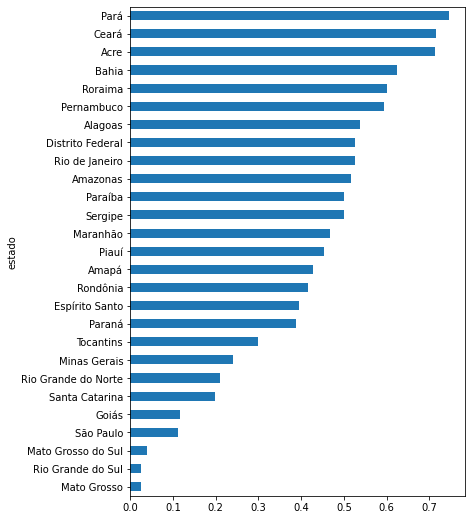

In [208]:
df_tmp = df_h[df_h['deactivated_proxy'] == False]

(df_tmp[df_tmp['updated_14d'] == False].groupby(['estado']).size() 
         / df_tmp.groupby(['estado']).size()
).sort_values().plot.barh(figsize=(6,9))

In [212]:
len(df_h[df_h.has_uti_proxy == True]) / len(df_h)

0.42452830188679247

<AxesSubplot:ylabel='estado'>

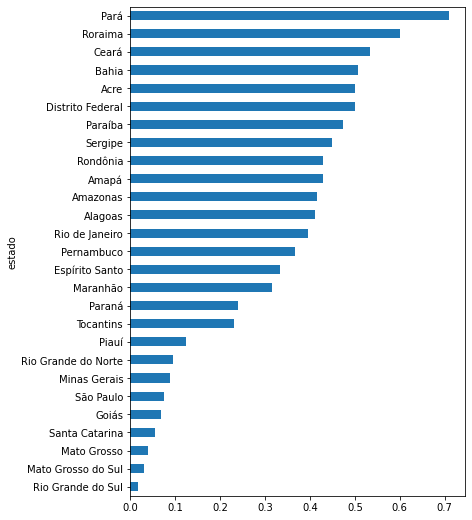

In [209]:
df_tmp = df_h[(df_h['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True)]

(df_tmp[df_tmp['updated_14d'] == False].groupby(['estado']).size() 
         / df_tmp.groupby(['estado']).size()
).sort_values().plot.barh(figsize=(6,9))

In [223]:
df_h.groupby(['tpGestao',]).size()

tpGestao
D     485
E     704
M    2382
dtype: int64

In [233]:
df_h.groupby(['tpGestao', 'natJuridica']).size()

tpGestao  natJuridica
D         1               155
          2                29
          3               301
E         1               419
          2                40
          3               245
M         1              1235
          2               355
          3               791
          4                 1
dtype: int64

In [ ]:
types_natJuridica = {
    '1': 'ADMINISTRAÇÃO PÚBLICA',
    '2': 'ENTIDADES EMPRESARIAIS',
    '3': 'ENTIDADES SEM FINS LUCRATIVOS',
    '4': 'PESSOAS FÍSICAS', # claramente um erro 
}

types_tpGestao = {
    'D': 'Dupla',
    'E': 'Estadual',
    'M': 'Municipal',
}

<AxesSubplot:ylabel='estado'>

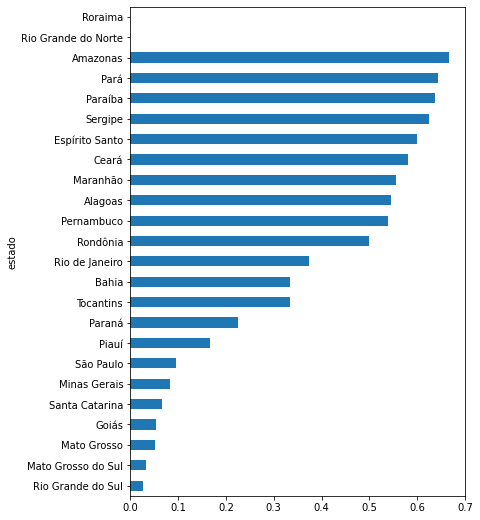

In [239]:
df_tmp = df_h[(df_h['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True) & (df_h.tpGestao == 'M')]

(df_tmp[df_tmp['updated_14d'] == False].groupby(['estado']).size() 
         / df_tmp.groupby(['estado']).size()
).sort_values().plot.barh(figsize=(6,9))

<AxesSubplot:ylabel='estado,tpGestao'>

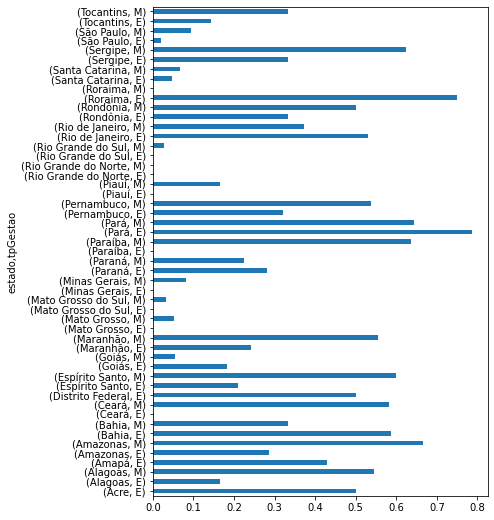

In [242]:
df_tmp = df_h[(df_h['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True) & (df_h.tpGestao.isin(['M', 'E']))]

(df_tmp[df_tmp['updated_14d'] == False].groupby(['estado', 'tpGestao']).size() 
         / df_tmp.groupby(['estado', 'tpGestao']).size()
).plot.barh(figsize=(6,9))

In [241]:
(df_tmp[df_tmp['updated_14d'] == False].groupby(['estado', 'tpGestao']).size() 
         / df_tmp.groupby(['estado', 'tpGestao']).size()
)

estado               tpGestao
Acre                 E           0.500000
Alagoas              E           0.166667
                     M           0.545455
Amapá                E           0.428571
Amazonas             E           0.285714
                     M           0.666667
Bahia                E           0.586207
                     M           0.333333
Ceará                E                NaN
                     M           0.581818
Distrito Federal     E           0.500000
Espírito Santo       E           0.210526
                     M           0.600000
Goiás                E           0.181818
                     M           0.054945
Maranhão             E           0.241379
                     M           0.555556
Mato Grosso          E                NaN
                     M           0.052632
Mato Grosso do Sul   E                NaN
                     M           0.033333
Minas Gerais         E                NaN
                     M           0.082353
Para

<AxesSubplot:ylabel='tpGestao'>

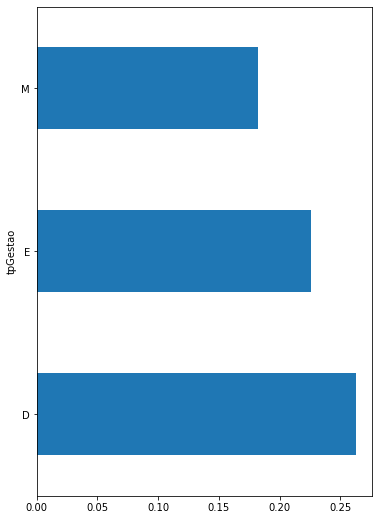

In [244]:
df_tmp = df_h[(df_h['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True) & (df_h.tpGestao.isin(['M', 'E', 'D']))]

(df_tmp[df_tmp['updated_14d'] == False].groupby(['tpGestao']).size() 
         / df_tmp.groupby(['tpGestao']).size()
).plot.barh(figsize=(6,9))

In [250]:
df_tmp = df_h[(df_h['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True) & (df_h.tpGestao.isin(['M', 'E']))]

df_tmp = (df_tmp[df_tmp['updated_14d'] == False].groupby(['estado', 'tpGestao']).size() 
         / df_tmp.groupby(['estado', 'tpGestao']).size()
)

df_tmp.reset_index().groupby(['tpGestao']).mean()

,0
tpGestao,
E,0.349695
M,0.351727
